In [1]:
from pathlib import Path
from typing import Callable, Dict, Optional
import numpy as np
import sys
sys.path.append('..')
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from skimage import io
from torchvision.transforms import ToTensor, Resize, CenterCrop
from data_handling.base import BaseDataModuleClass
from datetime import datetime

from data_handling.caching import SharedCache
from hydra import compose, initialize
# from data_handling.chest_xray import MimicDataset, MimicDataModule
from data_handling.sampler import SamplerFactory
from torch.utils.data import DataLoader
from causal_models.train_setup import setup_dataloaders
import matplotlib.pyplot as plt
from tqdm import tqdm



In [2]:
class Hparams:
    def update(self, dict):
        for k, v in dict.items():
            setattr(self, k, v)

args = Hparams()
args.hps = "mimic224_224_with_seg"
args.parents_x = ["finding", "race", "sex", "age"]
args.batch_size = 16
dataloaders = setup_dataloaders(args=args, cache=False, shuffle_train=False)

{'project_name': 'MIMIC_crop generation', 'seed': 11, 'mixed_precision': False, 'is_unit_test_config': False, 'data': {'batch_size': 16, 'num_workers': 12, 'pin_memory': True, 'input_channels': 1, 'weights': 'None', 'augmentations': {'resize': [224, 224], 'center_crop': 'None', 'random_rotation': 0, 'horizontal_flip': False, 'vertical_flip': False, 'random_crop': 'None', 'random_color_jitter': 0.1, 'random_erase_scale': [0.0, 0.0], 'sharp': 0.0}, 'prop_train': 1.0, '_target_': 'data_handling.chest_xray.MimicDataModule', 'dataset': 'mimic', 'domain': 'None', 'cache': False, 'seg_target_list': ['Left-Lung', 'Right-Lung', 'Heart']}, 'trainer': {'name': 'base', 'lr': 0.001, 'num_epochs': 400, 'patience_for_scheduler': 10, 'metric_to_monitor': 'Val/loss', 'metric_to_monitor_mode': 'min', 'val_check_interval': 'None', 'weight_decay': 0.0, 'use_train_augmentations': True, 'loss': 'ce', 'contrastive_temperature': 0.1, 'return_two_views': False, 'finetune_path': 'None', 'device': [0], 'max_step

/vol/biomedic3/tx1215/heartflow_mimic_crop/data_handling/../data_handling/chest_xray.py:129: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['disease'] = df['disease'].replace({'No Finding': 0, 'Pleural Effusion': 1})


sex
Male      0.516252
Female    0.483748
Name: proportion, dtype: float64
disease
No Finding          0.541031
Pleural Effusion    0.458969
Name: proportion, dtype: float64
race
White    0.764848
Black    0.188804
Asian    0.046348
Name: proportion, dtype: float64
Len dataset 9968
Test df: 


/vol/biomedic3/tx1215/heartflow_mimic_crop/data_handling/../data_handling/chest_xray.py:129: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['disease'] = df['disease'].replace({'No Finding': 0, 'Pleural Effusion': 1})


sex
Male      0.522024
Female    0.477976
Name: proportion, dtype: float64
disease
No Finding          0.546651
Pleural Effusion    0.453349
Name: proportion, dtype: float64
race
White    0.772491
Black    0.186999
Asian    0.040511
Name: proportion, dtype: float64
Len dataset 30535


/vol/biomedic3/tx1215/heartflow_mimic_crop/data_handling/../data_handling/chest_xray.py:129: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['disease'] = df['disease'].replace({'No Finding': 0, 'Pleural Effusion': 1})


In [3]:
train_set = dataloaders['train'].dataset

In [4]:
img_path = train_set.img_paths[0]
print(Path("/vol/biodata/data/chest_xray/mimic-cxr-jpg-1024/data")/img_path)

/vol/biodata/data/chest_xray/mimic-cxr-jpg-1024/data/preproc_1024x1024/s54299881_c4ca4bc3-56adf429-80528854-dd35290f-b36bf7a6.jpg


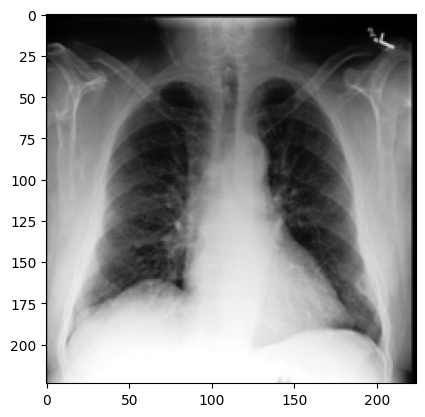

In [5]:
example_batch = train_set.__getitem__(69)

plt.imshow(example_batch['x'][0], cmap='gray')

In [6]:
print(example_batch['Left-Lung_volume'])

tensor([0.5093])


### Find max and min volumes of each seg

In [7]:
modes=['train','valid','test']
print(dataloaders['train'].dataset.seg_target_list)
min_volumes = {k: 100000000 for k in dataloaders['train'].dataset.seg_target_list}
max_volumes = {k: 0 for k in dataloaders['train'].dataset.seg_target_list}
min_index = {k: -1 for k in dataloaders['train'].dataset.seg_target_list}
max_index = {k: -1 for k in dataloaders['train'].dataset.seg_target_list}

for mode in modes:
    exclude_ids = []
    print(min_volumes.keys())
    for idx in  range(len(dataloaders[mode].dataset)):
        batch = dataloaders[mode].dataset.__getitem__(idx)
        for k in min_volumes.keys():
            # if batch[f"{k}_volume"].min() <300:
            #     if idx not in exclude_ids:
            #         exclude_ids.append(idx)
            #         continue
            # print(f"k: {k}, {batch[f'{k}_volume'].min()}")
            if min_volumes[k] > batch[f"{k}_volume"].min():
                min_volumes[k] = batch[f"{k}_volume"].min()
                min_index[k] = idx
            if max_volumes[k] < batch[f"{k}_volume"].max():
                max_volumes[k] = batch[f"{k}_volume"].max()
                max_index[k] = idx

['Left-Lung', 'Right-Lung', 'Heart']
dict_keys(['Left-Lung', 'Right-Lung', 'Heart'])
dict_keys(['Left-Lung', 'Right-Lung', 'Heart'])
dict_keys(['Left-Lung', 'Right-Lung', 'Heart'])


In [8]:
print(f"max_volumes: {max_volumes}")
print(f"min_volumes: {min_volumes}")


max_volumes: {'Left-Lung': tensor(0.9485), 'Right-Lung': tensor(0.9499), 'Heart': tensor(0.9221)}
min_volumes: {'Left-Lung': tensor(0.), 'Right-Lung': tensor(0.), 'Heart': tensor(0.)}


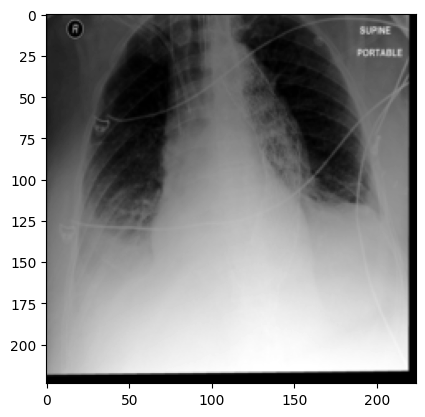

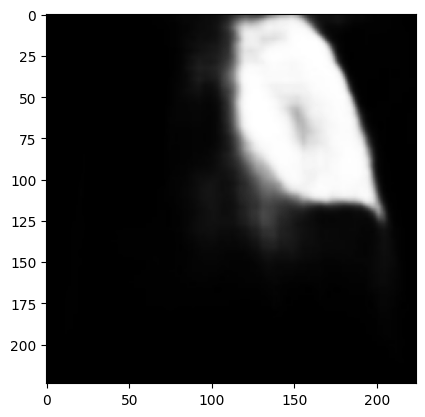

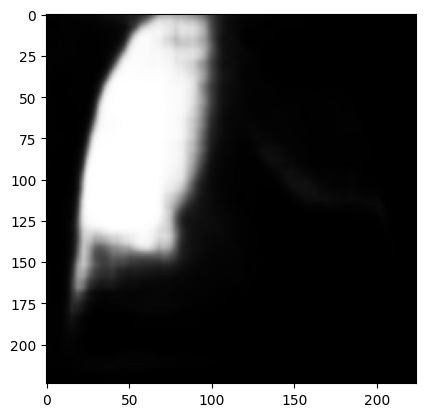

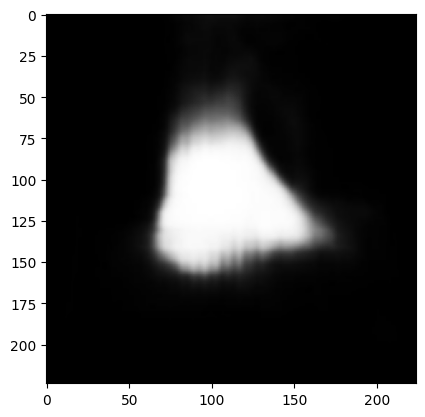

In [9]:
id = 651

batch = dataloaders[mode].dataset.__getitem__(id) 
segs = dataloaders[mode].dataset.read_segs(id)

plt.figure()
plt.imshow(batch['x'][0], cmap='gray')

plt.figure()
plt.imshow(segs['Left-Lung'][0], cmap="gray")

plt.figure()
plt.imshow(segs['Right-Lung'][0], cmap="gray")

plt.figure()
plt.imshow(segs['Heart'][0], cmap="gray")